<a href="https://colab.research.google.com/github/riyachandaria/BSc-Data-Science-Project/blob/main/covid_deaths_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
!pip install -q missingno
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
!pip install -q shap
import shap
from sklearn.model_selection import train_test_split
import xgboost as xgb

# **Step 1: Load data**

In [2]:
# Reading the data
file_path = 'https://raw.githubusercontent.com/owid/covid-19-data/refs/heads/master/public/data/owid-covid-data.csv'
df = pd.read_csv(file_path)

In [3]:
df.head(10)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
5,AFG,Asia,Afghanistan,2020-01-10,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
6,AFG,Asia,Afghanistan,2020-01-11,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
7,AFG,Asia,Afghanistan,2020-01-12,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
8,AFG,Asia,Afghanistan,2020-01-13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
9,AFG,Asia,Afghanistan,2020-01-14,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    429435 non-null  object 
 1   continent                                   402910 non-null  object 
 2   location                                    429435 non-null  object 
 3   date                                        429435 non-null  object 
 4   total_cases                                 411804 non-null  float64
 5   new_cases                                   410159 non-null  float64
 6   new_cases_smoothed                          408929 non-null  float64
 7   total_deaths                                411804 non-null  float64
 8   new_deaths                                  410608 non-null  float64
 9   new_deaths_smoothed                         409378 non-null  float64
 

In [5]:
df.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,4.118040e+05,4.101590e+05,4.089290e+05,4.118040e+05,410608.000000,409378.000000,411804.000000,410159.000000,408929.000000,411804.000000,...,243817.000000,161741.000000,290689.000000,390299.000000,319127.000000,4.294350e+05,1.341100e+04,13411.000000,13411.000000,13411.000000
mean,7.365292e+06,8.017360e+03,8.041026e+03,8.125957e+04,71.852139,72.060828,112096.199420,122.357073,122.713852,835.514337,...,33.097758,50.649390,3.106895,73.702098,0.722178,1.520336e+08,5.604765e+04,9.766431,10.925353,1772.666404
std,4.477582e+07,2.296649e+05,8.661611e+04,4.411901e+05,1368.322990,513.636565,162240.412405,1508.778585,559.701663,1134.932641,...,13.853952,31.905236,2.549168,7.387914,0.149237,6.975408e+08,1.568691e+05,12.040658,24.560706,1991.892770
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.700000,1.190000,0.100000,53.280000,0.390000,4.700000e+01,-3.772610e+04,-44.230000,-95.920000,-2936.450000
25%,6.280750e+03,0.000000e+00,0.000000e+00,4.300000e+01,0.000000,0.000000,1916.100000,0.000000,0.000000,24.570000,...,22.600000,20.860000,1.300000,69.500000,0.600000,5.237980e+05,1.765000e+02,2.060000,-1.500000,116.875000
50%,6.365300e+04,0.000000e+00,1.200000e+01,7.990000e+02,0.000000,0.000000,29145.480000,0.000000,2.790000,295.090000,...,33.100000,49.540000,2.500000,75.050000,0.740000,6.336393e+06,6.815200e+03,8.130000,5.660000,1270.800000
75%,7.582720e+05,0.000000e+00,3.132900e+02,9.574000e+03,0.000000,3.140000,156770.190000,0.000000,56.250000,1283.820000,...,41.500000,82.500000,4.210000,79.460000,0.830000,3.296952e+07,3.912804e+04,15.160000,15.575000,2883.025000
max,7.758668e+08,4.423623e+07,6.319461e+06,7.057132e+06,103719.000000,14817.000000,763598.600000,241758.230000,34536.890000,6601.110000,...,78.100000,100.000000,13.800000,86.750000,0.960000,7.975105e+09,1.349776e+06,78.080000,378.220000,10293.520000


In [6]:
# Find the minimum and maximum date
min_date = df['date'].min()
max_date = df['date'].max()
print(f"Date range: {min_date} to {max_date}")

Date range: 2020-01-01 to 2024-08-14


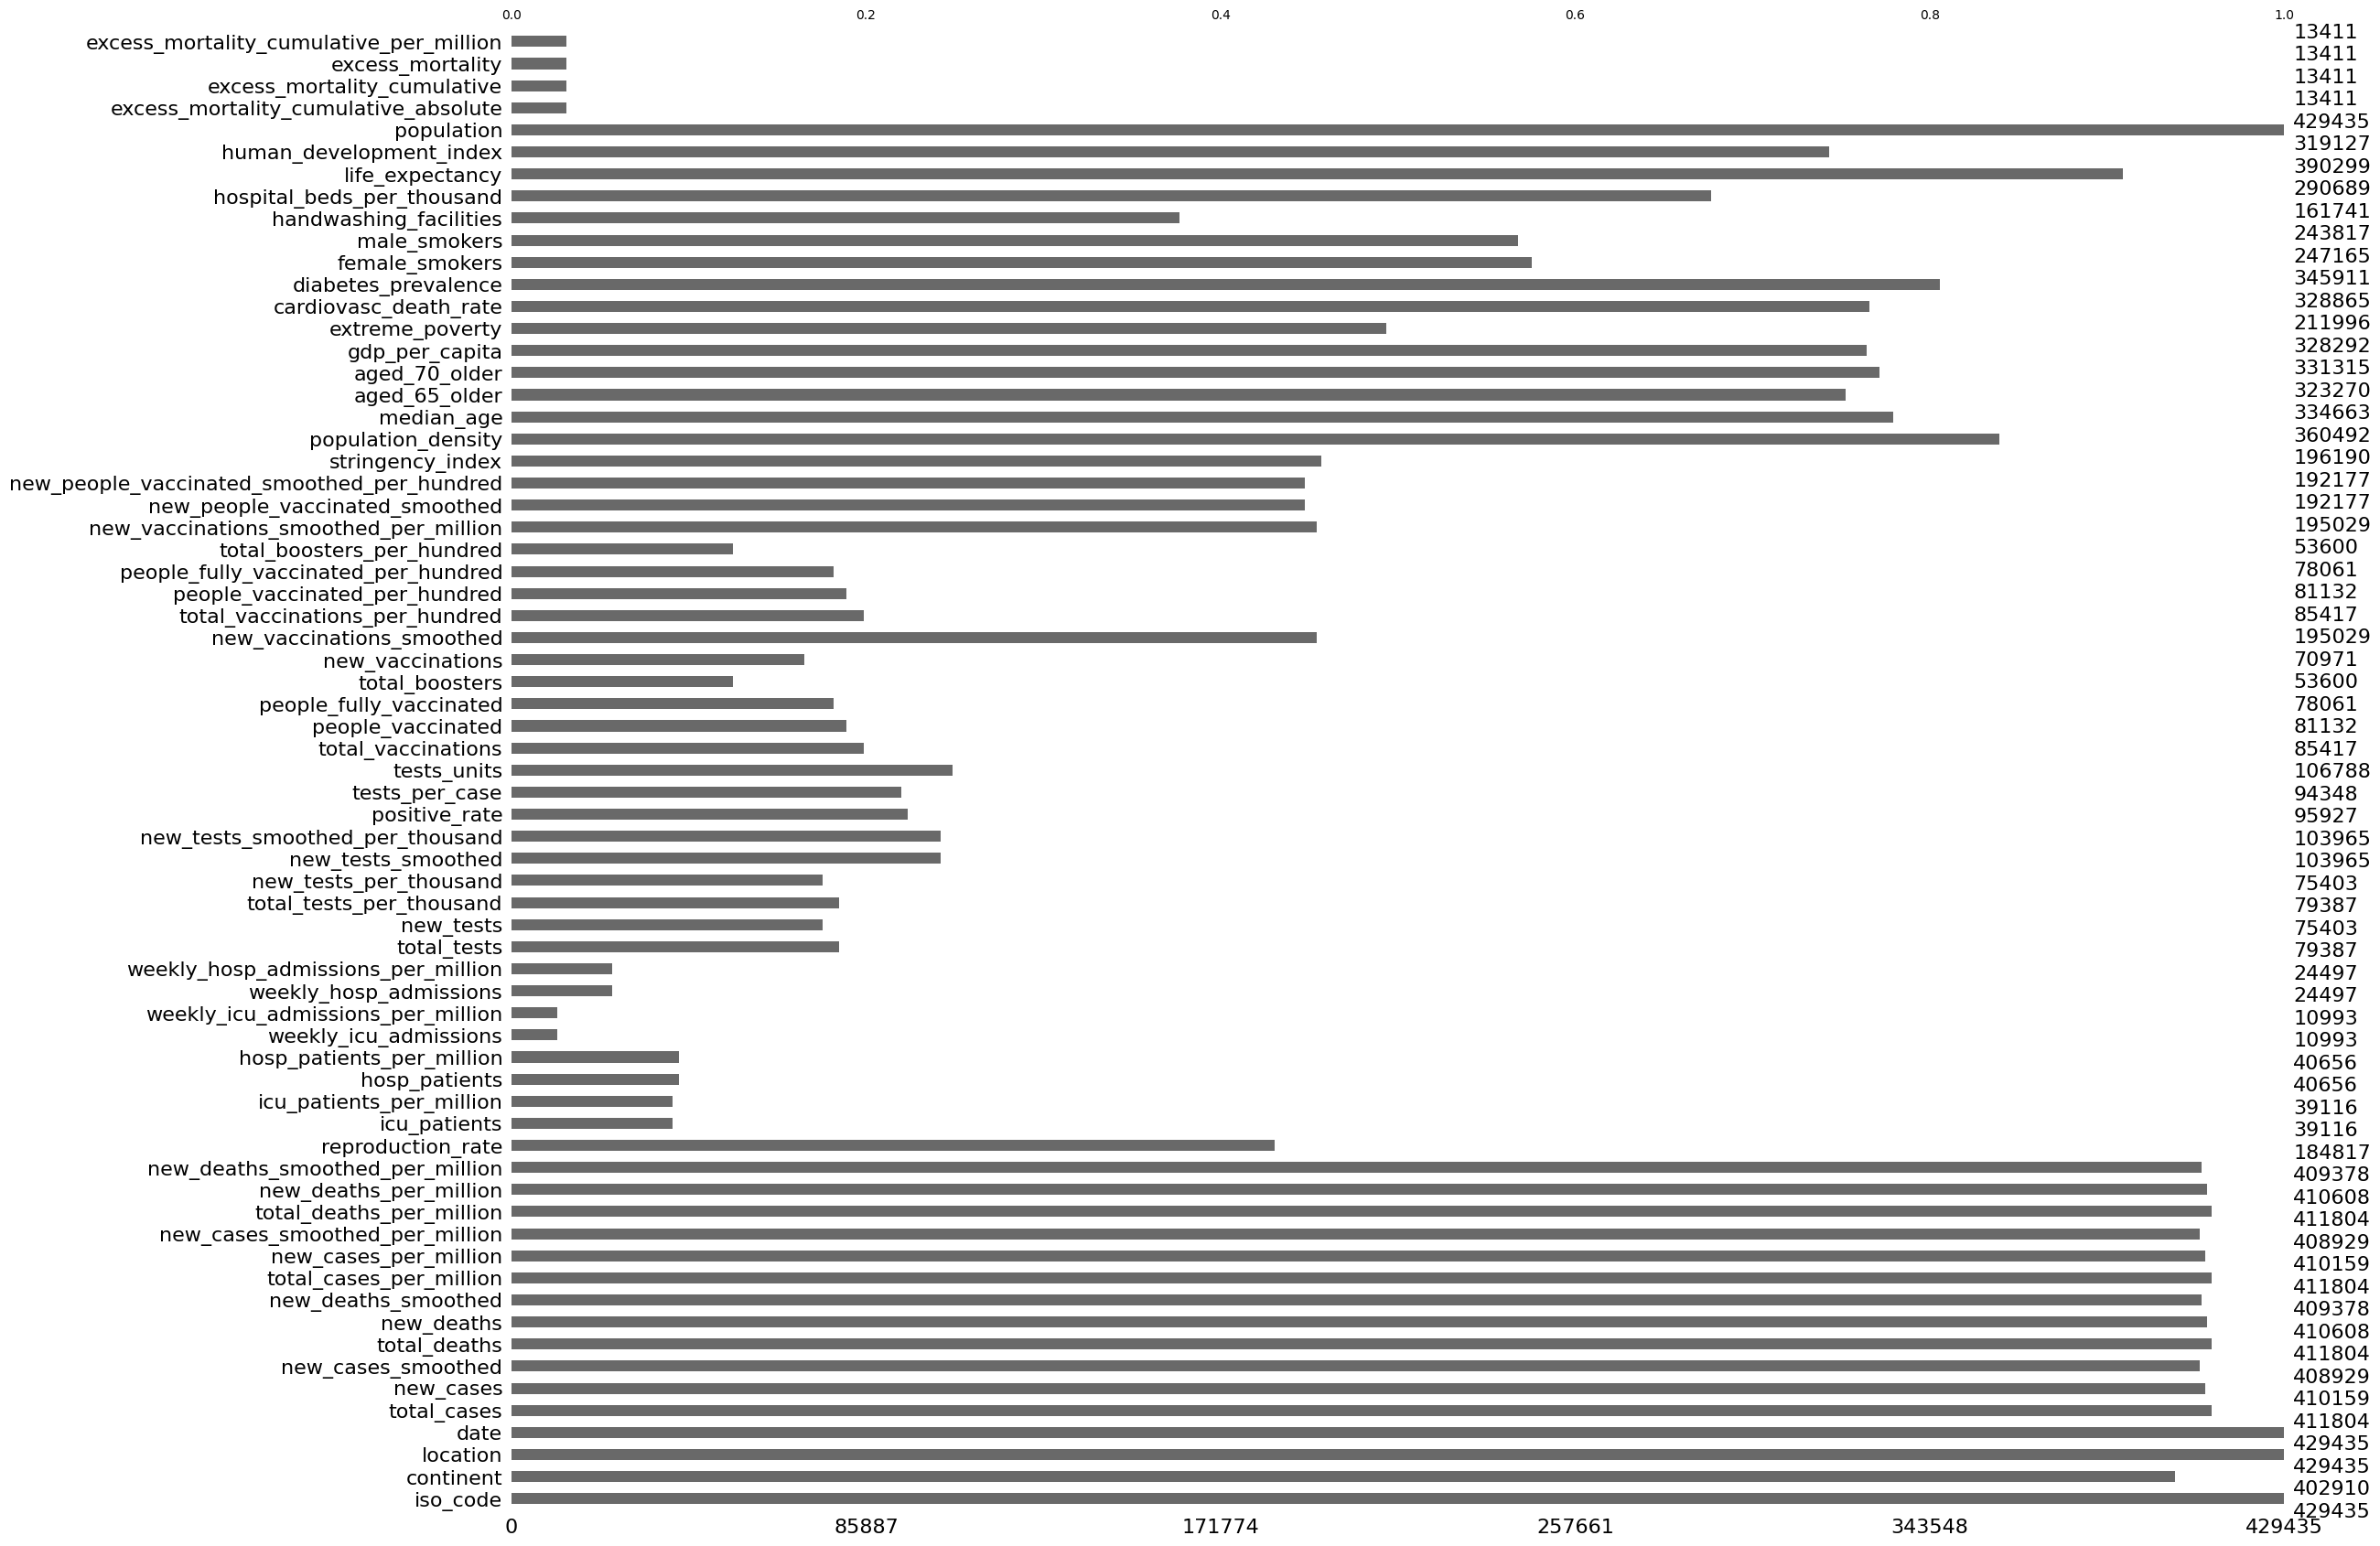

In [7]:
# Bar chart to see missing values count
msno.bar(df)
plt.show()

# **Step 2: Pre-processing**

In [8]:
## UK ONLY DATA

# Create a subset of the DataFrame for the UK
uk_df = df[df['location'] == 'United Kingdom']

uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1674 entries, 401777 to 403450
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    1674 non-null   object 
 1   continent                                   1674 non-null   object 
 2   location                                    1674 non-null   object 
 3   date                                        1674 non-null   object 
 4   total_cases                                 1674 non-null   float64
 5   new_cases                                   1674 non-null   float64
 6   new_cases_smoothed                          1669 non-null   float64
 7   total_deaths                                1674 non-null   float64
 8   new_deaths                                  1674 non-null   float64
 9   new_deaths_smoothed                         1669 non-null   float64
 10  total_case

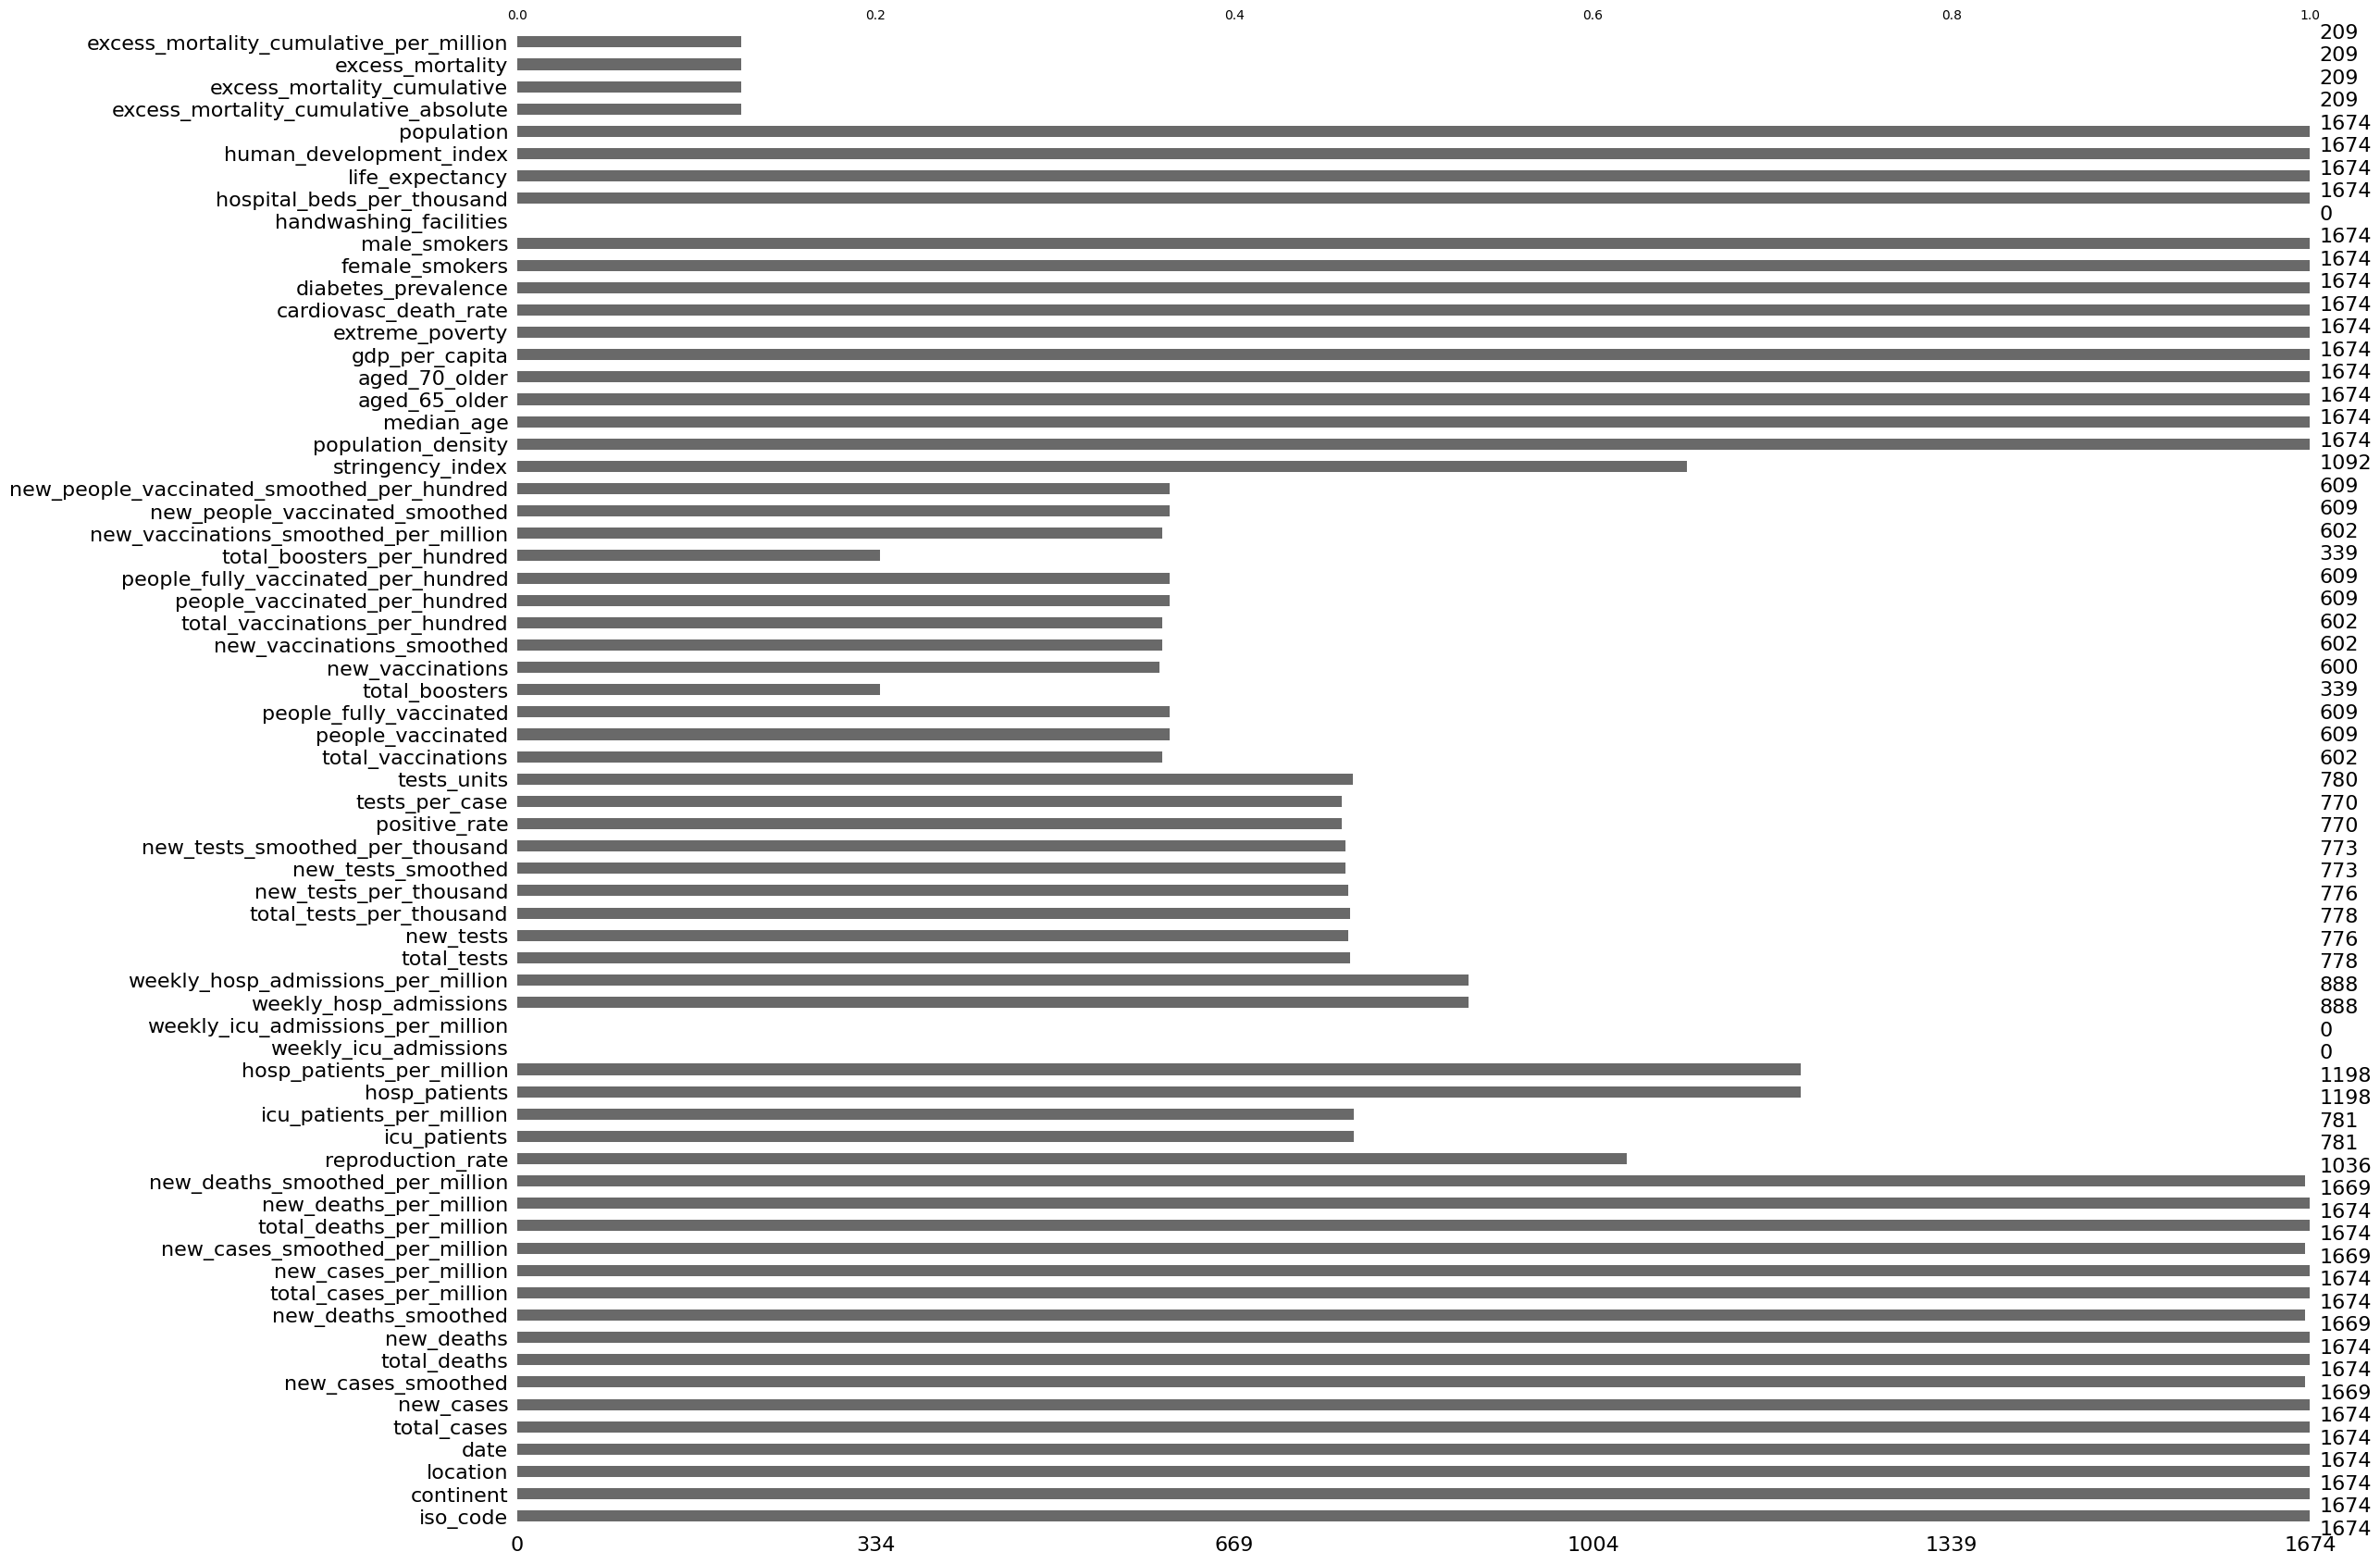

In [9]:
# Bar chart to see missing values count
msno.bar(uk_df)
plt.show()

In [10]:
## CLEANING & PREPROCESSING FUNCTION

# Function to selected desired columns and remove any NaNs
def cleaning_data_uk(df):

  # Creating copy of data
  cleaned_df = df.copy()

  # Convert 'date' column to datetime format
  cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])

  # Keep only the columns specified by index
  cleaned_df = cleaned_df[['date'] + cleaned_df.columns[[2, 4, 5, 7, 8] + list(range(48,58)) + list(range(59,63))].tolist()]

  # Removing any NaNs
  #cleaned_df = cleaned_df.dropna()

  # Return the cleaned dataframe
  return cleaned_df

cleaned_uk_df = cleaning_data_uk(uk_df)

In [11]:
cleaned_uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1674 entries, 401777 to 403450
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        1674 non-null   datetime64[ns]
 1   location                    1674 non-null   object        
 2   total_cases                 1674 non-null   float64       
 3   new_cases                   1674 non-null   float64       
 4   total_deaths                1674 non-null   float64       
 5   new_deaths                  1674 non-null   float64       
 6   population_density          1674 non-null   float64       
 7   median_age                  1674 non-null   float64       
 8   aged_65_older               1674 non-null   float64       
 9   aged_70_older               1674 non-null   float64       
 10  gdp_per_capita              1674 non-null   float64       
 11  extreme_poverty             1674 non-null   float64   

**Description of each column selected:** (taken from [OWID GitHub README.md page](https://github.com/owid/covid-19-data/blob/master/public/data/README.md))


*   **`date`**: Date of observation.
*   **`location`**: Geographical location.
*   **`total_cases`**: Total confirmed cases of COVID-19. Counts can include probable cases, where reported.
*   **`new_cases`**: New confirmed cases of COVID-19. Counts can include probable cases, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA.
*   **`total_deaths`**: Total deaths attributed to COVID-19. Counts can include probable deaths, where reported.
*   **`new_deaths`**: New deaths attributed to COVID-19. Counts can include probable deaths, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA.
* **`population_density`**: Number of people divided by land area, measured in square kilometers, most recent year available.
* **`median_age`**: 	Median age of the population, UN projection for 2020.
* **`aged_65_older`**: 	Share of the population that is 65 years and older, most recent year available.
* **`aged_70_older`**: Share of the population that is 70 years and older in 2015.
* **`gdp_per_capita`**: Gross domestic product at purchasing power parity (constant 2011 international dollars), most recent year available.
* **`extreme_poverty`**: Share of the population living in extreme poverty, most recent year available since 2010.
* **`cardiovasc_death_rate`**: Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people).
* **`diabetes_prevalence`**: Diabetes prevalence (% of population aged 20 to 79) in 2017.
* **`female_smokers`**: Share of women who smoke, most recent year available.
* **`male_smokers`**: Share of men who smoke, most recent year available.
* **`hospital_beds_per_thousand`**: Hospital beds per 1,000 people, most recent year available since 2010.
* **`life_expectancy`**: Life expectancy at birth in 2019.
* **`human_development_index`**: A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506.
* **`population`**: Population (latest available values). See https://github.com/owid/covid-19-data/blob/master/scripts/input/un/population_latest.csv for full list of sources.


# **Step 3: Exploratory Data Analysis (EDA)**

## **Cases**

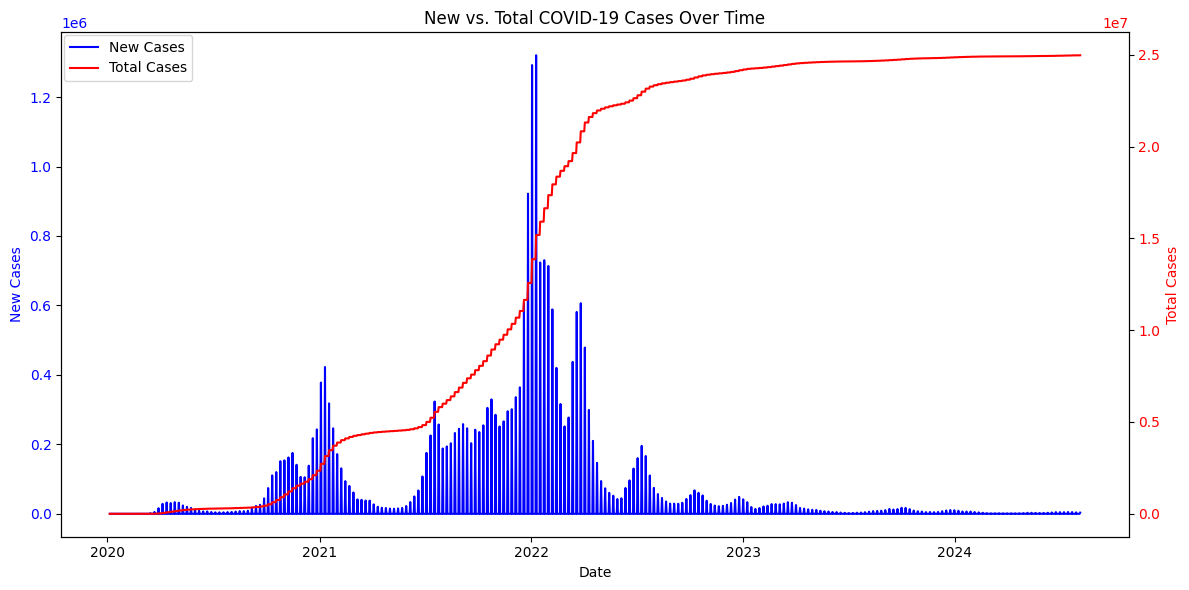

In [12]:
# New vs. Total COVID-19 Cases Over Time

# Group data by date and sum new cases and total cases
cases_over_time = cleaned_uk_df.groupby('date').agg({'new_cases': 'sum', 'total_cases': 'sum'})

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot new cases on the first y-axis
ax1.plot(cases_over_time.index, cases_over_time['new_cases'], color='blue', label='New Cases')
ax1.set_xlabel('Date')
ax1.set_ylabel('New Cases', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for total cases
ax2 = ax1.twinx()
ax2.plot(cases_over_time.index, cases_over_time['total_cases'], color='red', label='Total Cases')
ax2.set_ylabel('Total Cases', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Customize the plot
plt.title('New vs. Total COVID-19 Cases Over Time')
fig.legend(loc="upper left", bbox_to_anchor=(0.052, 0.945))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Deaths**

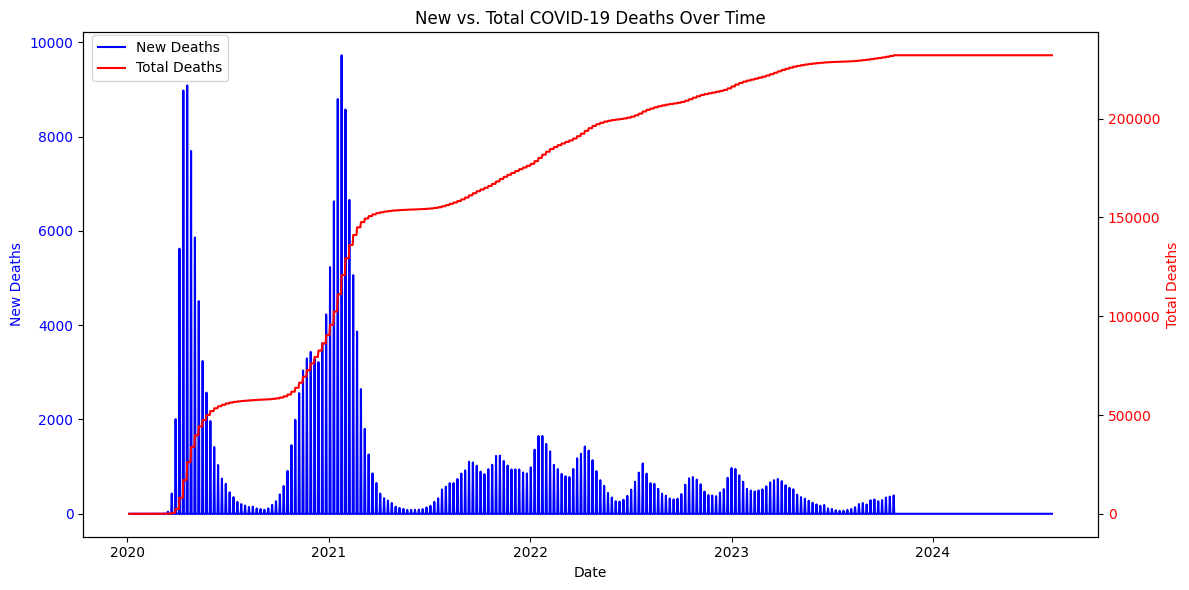

In [13]:
# New vs. Total COVID-19 deaths Over Time

# Group data by date and sum new cases and total cases
cases_over_time = cleaned_uk_df.groupby('date').agg({'new_deaths': 'sum', 'total_deaths': 'sum'})

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot new cases on the first y-axis
ax1.plot(cases_over_time.index, cases_over_time['new_deaths'], color='blue', label='New Deaths')
ax1.set_xlabel('Date')
ax1.set_ylabel('New Deaths', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for total cases
ax2 = ax1.twinx()
ax2.plot(cases_over_time.index, cases_over_time['total_deaths'], color='red', label='Total Deaths')
ax2.set_ylabel('Total Deaths', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Customize the plot
plt.title('New vs. Total COVID-19 Deaths Over Time')
fig.legend(loc="upper left", bbox_to_anchor=(0.075, 0.945))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Find the last date with a non-zero value in 'new_deaths'
last_nonzero_death_date = cleaned_uk_df[cleaned_uk_df['new_deaths'] != 0]['date'].max()
print(f"The last date a non-zero value was recorded in 'new_deaths' is: {last_nonzero_death_date}")

The last date a non-zero value was recorded in 'new_deaths' is: 2023-10-22 00:00:00


In [15]:
# Removing all data after 2023-10-22
cleaned_uk_df_2 = cleaned_uk_df[cleaned_uk_df['date'] <= '2023-10-22']

In [16]:
cleaned_uk_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1387 entries, 401777 to 403163
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        1387 non-null   datetime64[ns]
 1   location                    1387 non-null   object        
 2   total_cases                 1387 non-null   float64       
 3   new_cases                   1387 non-null   float64       
 4   total_deaths                1387 non-null   float64       
 5   new_deaths                  1387 non-null   float64       
 6   population_density          1387 non-null   float64       
 7   median_age                  1387 non-null   float64       
 8   aged_65_older               1387 non-null   float64       
 9   aged_70_older               1387 non-null   float64       
 10  gdp_per_capita              1387 non-null   float64       
 11  extreme_poverty             1387 non-null   float64   

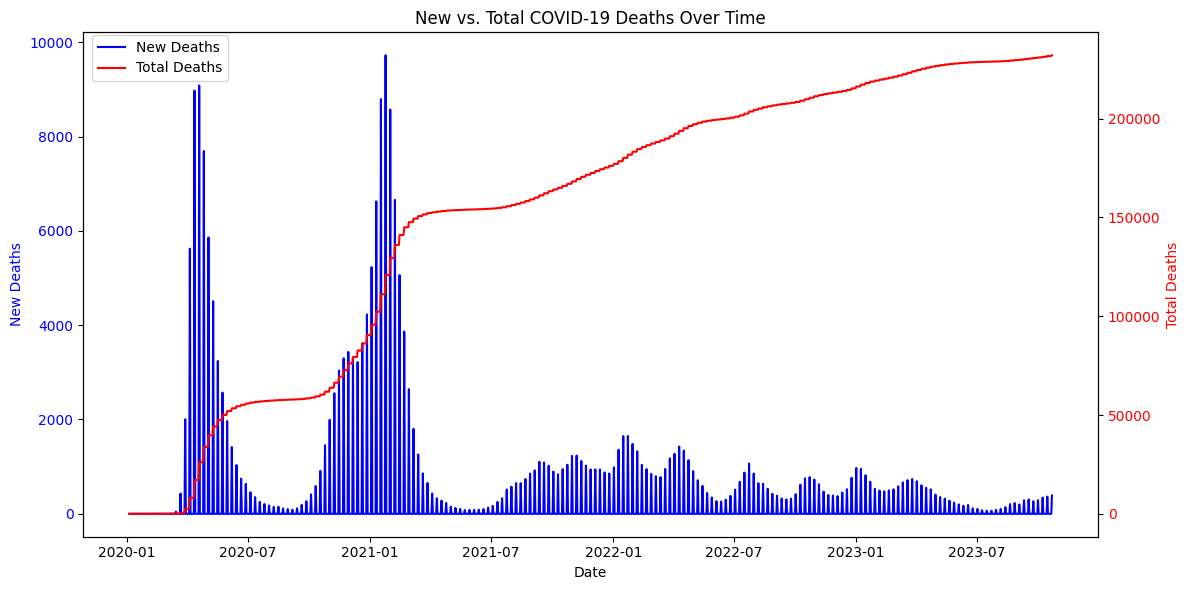

In [17]:
# New vs. Total COVID-19 deaths Over Time

# Group data by date and sum new cases and total cases
cases_over_time = cleaned_uk_df_2.groupby('date').agg({'new_deaths': 'sum', 'total_deaths': 'sum'})

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot new cases on the first y-axis
ax1.plot(cases_over_time.index, cases_over_time['new_deaths'], color='blue', label='New Deaths')
ax1.set_xlabel('Date')
ax1.set_ylabel('New Deaths', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for total cases
ax2 = ax1.twinx()
ax2.plot(cases_over_time.index, cases_over_time['total_deaths'], color='red', label='Total Deaths')
ax2.set_ylabel('Total Deaths', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Customize the plot
plt.title('New vs. Total COVID-19 Deaths Over Time')
fig.legend(loc="upper left", bbox_to_anchor=(0.075, 0.945))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Filter out rows where 'new_deaths' is zero
non_zero_deaths = cleaned_uk_df_2[cleaned_uk_df_2['new_deaths'] != 0]

# Get the first 20 non-zero 'new_deaths' values and their corresponding dates
first_non_zero = non_zero_deaths[['date', 'new_deaths']].head(20)

first_non_zero

,date,new_deaths
401805,2020-02-02,1.0
401812,2020-02-09,1.0
401833,2020-03-01,1.0
401840,2020-03-08,6.0
401847,2020-03-15,46.0
401854,2020-03-22,429.0
401861,2020-03-29,2005.0
401868,2020-04-05,5622.0
401875,2020-04-12,8974.0
401882,2020-04-19,9082.0


In [19]:
# Calculate the difference in dates between consecutive entries
date_diffs = first_non_zero['date'].diff().dt.days

date_diffs

,date
401805,NaN
401812,7.0
401833,21.0
401840,7.0
401847,7.0
401854,7.0
401861,7.0
401868,7.0
401875,7.0
401882,7.0


In [20]:
# Remove rows where 'new_deaths' is zero
cleaned_uk_df_3 = cleaned_uk_df_2[cleaned_uk_df_2['new_deaths'] != 0]

cleaned_uk_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 401805 to 403163
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        193 non-null    datetime64[ns]
 1   location                    193 non-null    object        
 2   total_cases                 193 non-null    float64       
 3   new_cases                   193 non-null    float64       
 4   total_deaths                193 non-null    float64       
 5   new_deaths                  193 non-null    float64       
 6   population_density          193 non-null    float64       
 7   median_age                  193 non-null    float64       
 8   aged_65_older               193 non-null    float64       
 9   aged_70_older               193 non-null    float64       
 10  gdp_per_capita              193 non-null    float64       
 11  extreme_poverty             193 non-null    float64    

In [21]:
cleaned_uk_df_3.head()

,date,location,total_cases,new_cases,total_deaths,new_deaths,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index,population
401805,2020-02-02,United Kingdom,1.0,1.0,1.0,1.0,272.9,40.8,18.52,12.53,39753.24,0.2,122.14,4.28,20.0,24.7,2.54,81.32,0.93,67508936
401812,2020-02-09,United Kingdom,21.0,20.0,2.0,1.0,272.9,40.8,18.52,12.53,39753.24,0.2,122.14,4.28,20.0,24.7,2.54,81.32,0.93,67508936
401833,2020-03-01,United Kingdom,68.0,33.0,3.0,1.0,272.9,40.8,18.52,12.53,39753.24,0.2,122.14,4.28,20.0,24.7,2.54,81.32,0.93,67508936
401840,2020-03-08,United Kingdom,379.0,311.0,9.0,6.0,272.9,40.8,18.52,12.53,39753.24,0.2,122.14,4.28,20.0,24.7,2.54,81.32,0.93,67508936
401847,2020-03-15,United Kingdom,2280.0,1901.0,55.0,46.0,272.9,40.8,18.52,12.53,39753.24,0.2,122.14,4.28,20.0,24.7,2.54,81.32,0.93,67508936


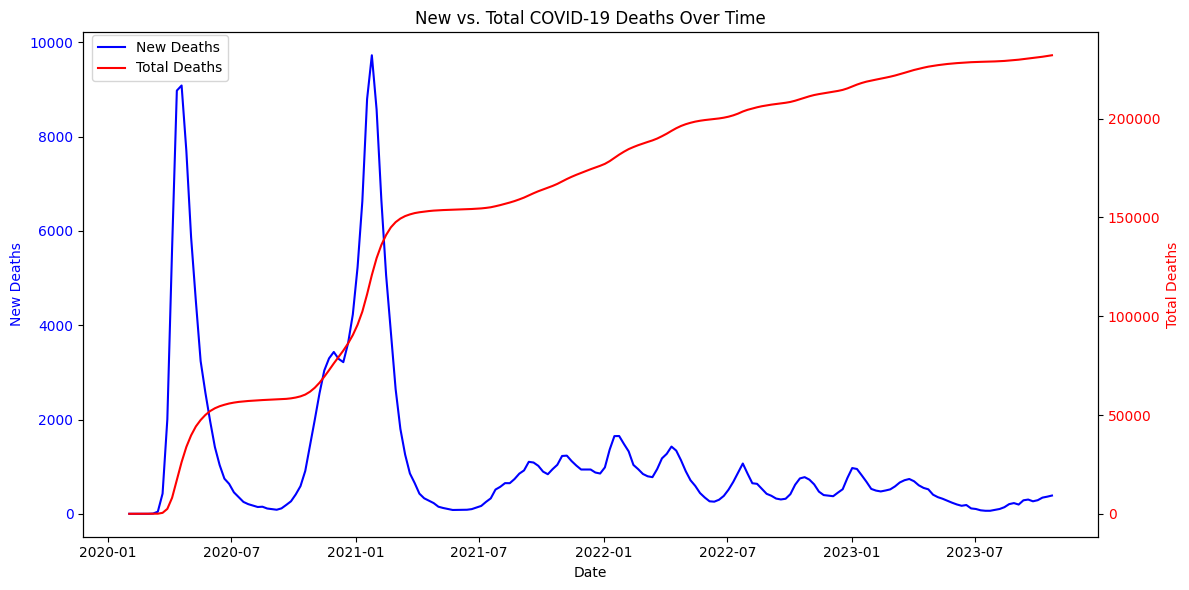

In [22]:
# New vs. Total COVID-19 deaths Over Time

# Group data by date and sum new cases and total cases
cases_over_time = cleaned_uk_df_3.groupby('date').agg({'new_deaths': 'sum', 'total_deaths': 'sum'})

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot new cases on the first y-axis
ax1.plot(cases_over_time.index, cases_over_time['new_deaths'], color='blue', label='New Deaths')
ax1.set_xlabel('Date')
ax1.set_ylabel('New Deaths', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for total cases
ax2 = ax1.twinx()
ax2.plot(cases_over_time.index, cases_over_time['total_deaths'], color='red', label='Total Deaths')
ax2.set_ylabel('Total Deaths', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Customize the plot
plt.title('New vs. Total COVID-19 Deaths Over Time')
fig.legend(loc="upper left", bbox_to_anchor=(0.075, 0.945))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Step 4: LSTM Model**

In [23]:
# Filter data from 2020-02-02 onwards
data = cleaned_uk_df_3[cleaned_uk_df_3['date'] >= '2020-02-02']
data.set_index('date', inplace=True)

# Selecting target variable
target_col = 'new_deaths'
target_data = data[[target_col]].values

# Normalizing the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(target_data)

# Function to create sequences for LSTM input
def create_sequences(data, sequence_length=30):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Create sequences
sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and validation sets
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.0336 - val_loss: 0.0037
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0287 - val_loss: 0.0069
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0257 - val_loss: 0.0031
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0242 - val_loss: 0.0017
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0243 - val_loss: 0.0021
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0244 - val_loss: 0.0043
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0219 - val_loss: 0.0080
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0190 - val_loss: 0.0061
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0117 - val_loss: 0.0027
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0154 - val_loss: 0.0023
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0129 - val_loss: 0.0044
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0123 - val_loss: 0.0096


In [24]:
# Making predictions
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


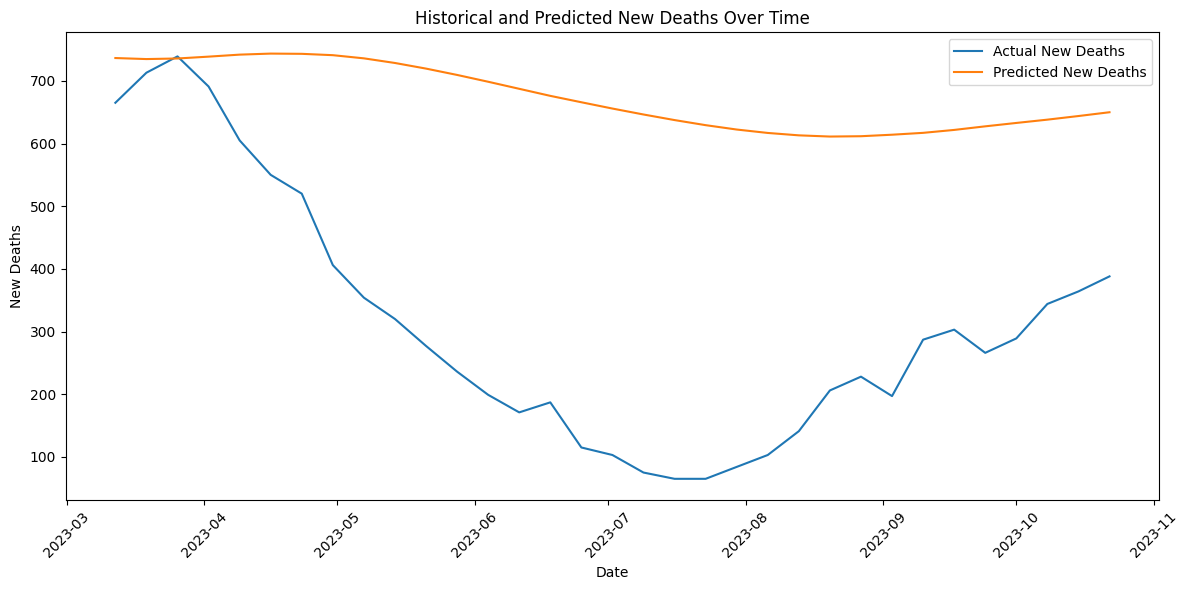

In [25]:
# prompt: create a plot of historic and predicted data over time from the lstm model

# Plotting historical and predicted data over time
plt.figure(figsize=(12, 6))
plt.plot(data.index[split + sequence_length:], y_val_rescaled, label='Actual New Deaths')
plt.plot(data.index[split + sequence_length:], predictions, label='Predicted New Deaths')
plt.title('Historical and Predicted New Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **LSTM Model Explanation**
**1. Data Preprocessing**

* The dataset is first **filtered** to include only the United Kingdom's data.
* **Irrelevant columns** are removed, and the `date` column is converted to a **datetime format**.
* All records **after 22nd October 2023** are **removed** to maintain a proper training dataset.
* Rows where **`new_deaths` is zero** are dropped, likely to prevent misleading trends in modeling.
* Data is further filtered to include **only dates from 2nd February 2020** onward.

**2. Normalization & Sequence Creation**

* **Min-Max Scaling** is applied to normalize `new_deaths` between 0 and 1, making it easier for the model to learn.
* A **sequence length of 30** is used, meaning the model **learns from the past 30 days** to predict the next day's deaths.

**3. LSTM Model Architecture**

* **Layer 1**: LSTM layer with 50 units, returning sequences for the next layer.
* **Layer 2**: Another LSTM layer with 50 units (not returning sequences).
* **Layer 3**: A Dense (fully connected) layer with **one neuron** to predict the next day's value.
* **Optimizer**: Adam (adaptive learning) is used with **Mean Squared Error (MSE)** as the loss function.

**4. Training the Model**

* **EarlyStopping** is used to **prevent overfitting** by stopping training if validation loss does not improve for 10 epochs.
* **80% of the data** is used for training, and **20% is reserved** for validation.
* The model is trained for **50 epochs**, but training may stop earlier if validation loss stagnates.


---


## **Historical and Predicted New Deaths Over Time**
📆 **What It Shows**:

This plot provides a broader view of model predictions **over time**.

* **X-axis**: **Date** (real calendar dates)
* **Y-axis**: **New deaths**
* **Two lines**:
    * **Actual historical deaths** (real data)
    * **Predicted deaths** (forecast by LSTM)

✅ **Key Insights**:

* If predictions align well with actual values, it indicates the model has successfully **captured patterns** in the data.
* If the **predicted values diverge**, the model may be struggling with long-term dependencies or handling sudden spikes in new deaths.


---


## **Summary of the LSTM Model Performance**

* The **historical vs. predicted plot** gives a **time-based perspective** of model accuracy.

## **Detailed Explanation of the Data Splitting Process**

When training a machine learning model, it is essential to divide the dataset into **training** and **validation** sets. This ensures that the model learns from one portion of the data while being evaluated on unseen data to test its generalization ability.

---

## **Step-by-Step Breakdown of the Split**
After creating sequences using past 30 days (`sequence_length = 30`), we perform the split using:

```python
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
```

Let’s break this down:

### **1. Understanding `split = int(0.8 * len(X))`**
- `len(X)` gives the total number of **sequences** (input samples).
- `0.8 * len(X)` takes **80% of the sequences** for training.
- `int()` ensures the split index is an **integer** (since we cannot split at a decimal index).

👉 **Example Calculation**  
Let’s assume `len(X) = 1000` (i.e., we have 1000 sequences available after preprocessing).  

- `0.8 * 1000 = 800`  
- `split = 800`, meaning **first 800 sequences** go to training, and the remaining **200 sequences** go to validation.

---

### **2. Assigning Training and Validation Data**
After computing the `split` index, we split the sequences and targets as follows:

#### **Training Set (80%)**
```python
X_train, y_train = X[:split], y[:split]
```
- `X_train = X[:800]` → First **800 sequences** are used for training.
- `y_train = y[:800]` → First **800 labels (new_deaths values)** correspond to `X_train`.

#### **Validation Set (20%)**
```python
X_val, y_val = X[split:], y[split:]
```
- `X_val = X[800:]` → Remaining **200 sequences** are used for validation.
- `y_val = y[800:]` → Corresponding **200 labels** for validation.

---

## **Why Split in This Way?**
1. **Ensures the model learns patterns**  
   - The model trains on 80% of the available sequences to learn patterns in **new deaths** over time.

2. **Prevents overfitting**  
   - If we used **100% of the data** for training, the model might "memorize" the data instead of generalizing.  
   - The validation set checks if the model performs well on unseen data.

3. **Preserves the time series order**  
   - Since **time series data has a chronological order**, we **do not shuffle the data**.  
   - Instead, we **take the first 80% as training** and **the last 20% as validation** to **simulate real-world forecasting**.

---

## **What Does This Mean for Model Training?**
- The **training set (X_train, y_train)** helps the LSTM model learn relationships between past 30 days and the next day's `'new_deaths'`.
- The **validation set (X_val, y_val)** is used to measure how well the model can predict future values it has **never seen before**.

### **Example Data Split in a Table**
| Sequence Index | Used For | Input (X) - Last 30 Days | Output (y) - Next Day |
|---------------|---------|--------------------------|----------------------|
| 0 - 799       | Training  | Days 1-30 → Predict Day 31  | y = Day 31 |
| 1 - 800       | Training  | Days 2-31 → Predict Day 32  | y = Day 32 |
| ...           | Training  | ...                      | ...      |
| 799 - 999     | Validation  | Days 800-829 → Predict Day 830  | y = Day 830 |
| 800 - 1000    | Validation  | Days 801-830 → Predict Day 831  | y = Day 831 |

Since **each sequence is 30 days long**, the model learns patterns using historical data and then attempts to predict the **next** day's value.

---

## **Final Summary**
1. **The dataset was split into training (80%) and validation (20%) sets.**
2. **The first 80% of the sequences** were used for **training**.
3. **The last 20% of the sequences** were used for **validation**, ensuring proper forecasting evaluation.
4. **The chronological order was preserved** to avoid data leakage.
5. The **model was trained to learn from 30 past days** and predict the **next day's new deaths**.


# **Step 5: Performance Assessment**

In [26]:
# Accuracy metrics

mae = mean_absolute_error(y_val_rescaled, predictions)
mse = mean_squared_error(y_val_rescaled, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_rescaled, predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 362.88
Mean Squared Error (MSE): 159085.94
Root Mean Squared Error (RMSE): 398.86
R² Score: -3.0602


### **How These Metrics Help?**
1. **MAE (Mean Absolute Error)** → Measures how much the predictions deviate from the actual values on average.
   - Lower **MAE** = better model.
   
2. **MSE (Mean Squared Error)** → Similar to MAE but penalizes large errors more.
   - Lower **MSE** = better model.

3. **RMSE (Root Mean Squared Error)** → Interpreted in the same units as the target variable.
   - Lower **RMSE** = better model.

4. **R² Score (Coefficient of Determination)** → Measures how well the model explains variance in the data.
   - **R² = 1** means **perfect prediction**.
   - **R² close to 0** means the model is no better than predicting the mean.


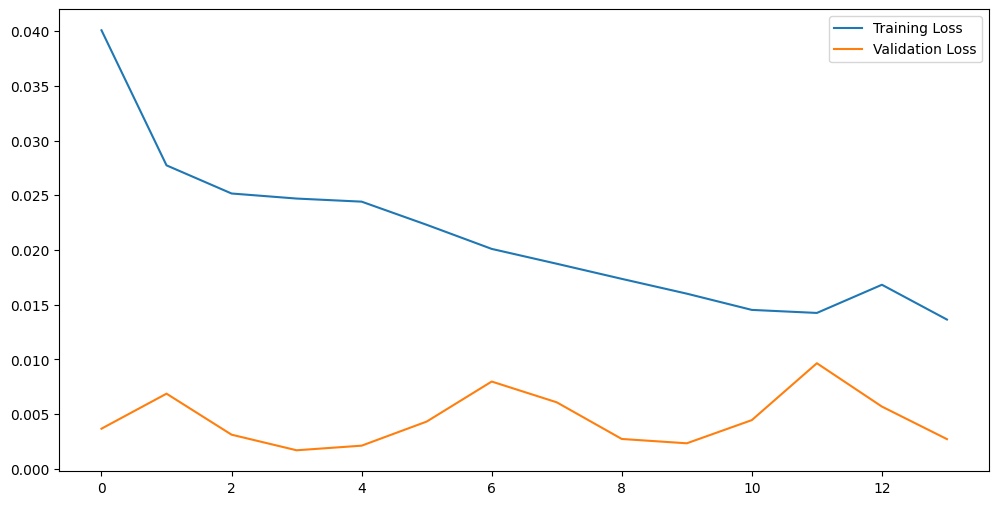

In [27]:
# Evaluate the model
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

## **Training and Validation Loss Curve**
📈 **What It Shows**:

This plot visualizes how the model's loss (error) evolves over time.

* **X-axis**: Epochs (number of times the model iterates over the dataset)
* **Y-axis**: Loss (MSE)
* **Two lines**:
    * **Training Loss** (how well the model fits the training data)
    * **Validation Loss** (how well it generalizes to unseen data)

✅ Ideal Case:

* The **training and validation losses** should both **decrease** and eventually plateau.
* If validation loss **rises while training loss keeps decreasing**, it means **overfitting**.

---

## **Summary of the LSTM Model Performance**

* The **loss plot** helps identify whether the model is overfitting.

# **Step 6: Explainable AI (XAI)**

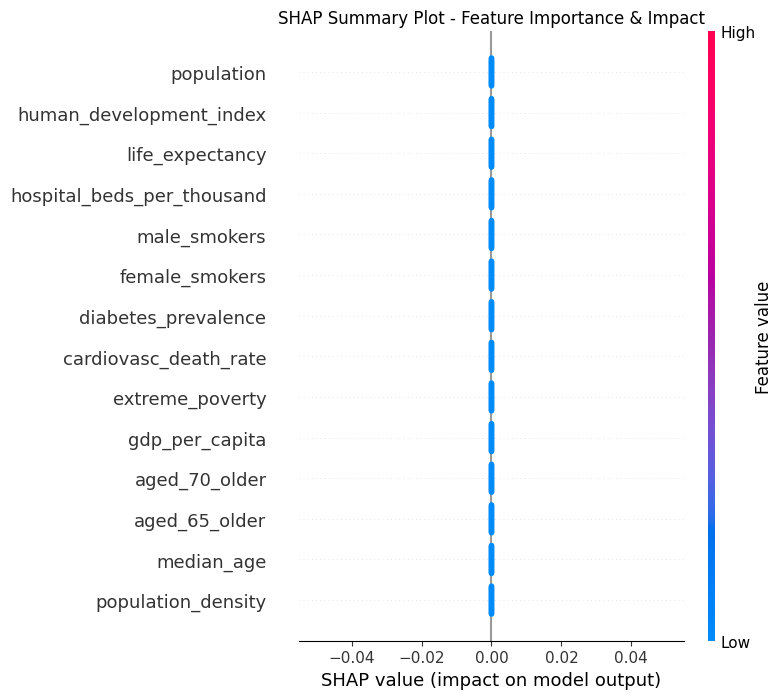

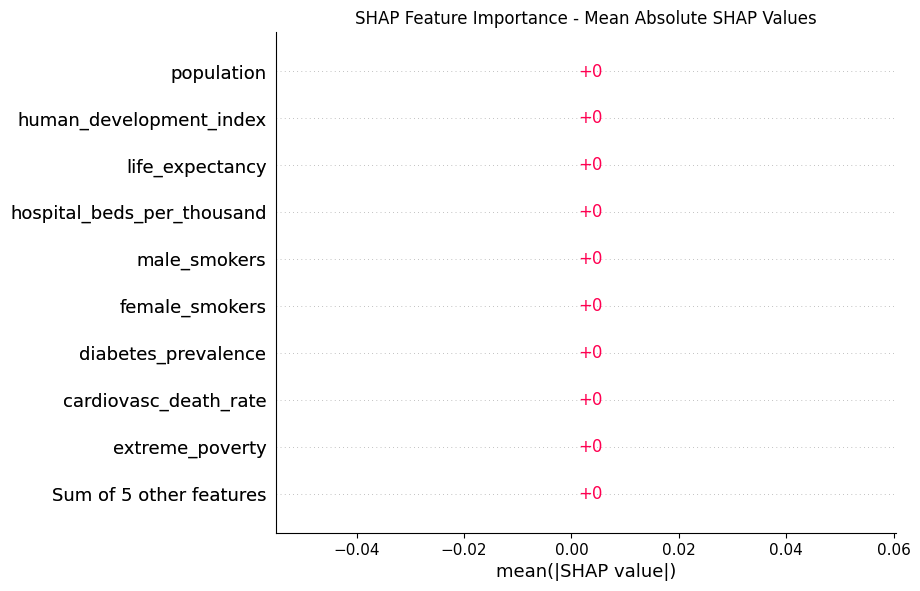

In [286]:
# Step 1: Select features and target variable
features = ['population_density',
            'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita',
            'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence',
            'female_smokers', 'male_smokers', 'hospital_beds_per_thousand',
            'life_expectancy', 'human_development_index', 'population']

# features = ['total_cases', 'new_cases', 'total_deaths', 'population_density',
#             'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita',
#             'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence',
#             'female_smokers', 'male_smokers', 'hospital_beds_per_thousand',
#             'life_expectancy', 'human_development_index', 'population']

target = 'new_deaths'

X = cleaned_uk_df_3[features]
y = cleaned_uk_df_3[target]

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Model Training and Prediction
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

def xai_xgboost_shap(df, features, target, test_size=0.2, random_state=42):
    """
    Train an XGBoost model and use SHAP for explainability.

    Parameters:
    - df: DataFrame containing the dataset.
    - features: List of feature column names.
    - target: Name of the target variable.
    - test_size: Proportion of data for testing (default=0.2).
    - random_state: Random seed for reproducibility.

    Returns:
    - None (Displays SHAP summary plot & feature importance).
    """

    # Step 1: Explainability using SHAP
    explainer = shap.Explainer(xgb_model, X_train)
    shap_values = explainer(X_test)

    # Step 2: Plot SHAP summary plot
    plt.figure(figsize=(10, 6))
    plt.title('SHAP Summary Plot - Feature Importance & Impact')
    shap.summary_plot(shap_values, X_test)
    plt.show()

    # Step 3: Plot SHAP feature importance
    plt.figure(figsize=(10, 6))
    plt.title('SHAP Feature Importance - Mean Absolute SHAP Values')
    shap.plots.bar(shap_values)
    plt.show()

# Run the XAI function
xai_xgboost_shap(cleaned_uk_df_3, features, target)